# FPH annual report probability visualisation
This notebook loads Fisher & Paykel Healthcare (FPH) annual report BERT outputs (finance, social, env, maori probabilities), combines them with a year column, and plots trends of how often each label is predicted strongly at three thresholds: >0.5, >0.75, >0.95.


In [1]:
# One-time install of plotting libraries (uncomment if needed)
%pip install -q matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

CODE_PREFIX = "FSF"

data_dir = Path("data")
csv_paths = sorted(data_dir.glob(f"preds-FSF*.csv"))
page_counts_path = Path("outputs/page_counts.csv")

csv_paths


[PosixPath('data/preds-FSF2013.csv'),
 PosixPath('data/preds-FSF2014.csv'),
 PosixPath('data/preds-FSF2015.csv'),
 PosixPath('data/preds-FSF2016.csv'),
 PosixPath('data/preds-FSF2017.csv'),
 PosixPath('data/preds-FSF2018.csv'),
 PosixPath('data/preds-FSF2019.csv'),
 PosixPath('data/preds-FSF2020.csv'),
 PosixPath('data/preds-FSF2021.csv'),
 PosixPath('data/preds-FSF2022.csv'),
 PosixPath('data/preds-FSF2023.csv'),
 PosixPath('data/preds-FSF2024.csv')]

In [3]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    frames = []
    for path in paths:
        year = int(path.stem.replace(f"preds-{CODE_PREFIX}", ""))
        df = pd.read_csv(path)
        df["year"] = year
        df["word_count"] = df["sentence"].fillna("").str.split().str.len()
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def load_page_counts(path):
    if not path.exists():
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts = pd.read_csv(path)
    required_cols = {"code_year", "pages"}
    missing_cols = required_cols - set(page_counts.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in page counts file: {missing_cols}")
    page_counts = page_counts[page_counts["code_year"].astype(str).str.startswith(CODE_PREFIX)]
    if page_counts.empty:
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts["year"] = page_counts["code_year"].str.extract(r"(\d{4})").astype(int)
    page_counts = page_counts[["year", "pages"]].rename(columns={"pages": "page_count"})
    return page_counts

# Run scripts/page_counts.py to generate outputs/page_counts.csv from PDFs in reports/
page_counts = load_page_counts(page_counts_path)

df = load_yearly(csv_paths)
df.head()


,sentence,source_page,source_pdf,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label,year
0,THE FIRST YEAR ANNUAL REPORT 2013 FONTERRA SHAREHOLDERS’ FUND,1,FSF2013,0.005753,0.998366,0.003589,0.000771,2013
1,"FONTERRA SHAREHOLDERS’ FUND 1 chairman’s report Dear Investors, It is my pleasure to present the first Fonterra Shar...",3,FSF2013,0.997209,0.022981,0.001735,0.001154,2013
2,The Fund offers investors a unique opportunity to invest in the performance of Fonterra Co-operative Group.,3,FSF2013,0.999360,0.002933,0.003938,0.003774,2013
3,"It continues to be well supported by both institutional and retail investors, which reflects the level of interest a...",3,FSF2013,0.999601,0.003266,0.003651,0.003978,2013
4,"Since the return on a Unit is driven by the underlying performance of Fonterra, investors are encouraged to read Fon...",3,FSF2013,0.999118,0.002514,0.004549,0.002720,2013


In [4]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


,year,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label
count,4181.000000,4181.000000,4181.000000,4181.000000,4181.000000
mean,2018.723989,0.323478,0.470883,0.182692,0.008962
std,3.544707,0.423781,0.466303,0.337390,0.076362
min,2013.000000,0.000426,0.000168,0.000200,0.000039
25%,2015.000000,0.003933,0.003371,0.002477,0.000717
50%,2019.000000,0.022302,0.271241,0.007280,0.001357
75%,2022.000000,0.872095,0.996537,0.114700,0.002494
max,2024.000000,0.999612,0.999173,0.999441,0.999250


In [5]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(
    id_vars=["year", "word_count"],
    value_vars=prob_cols,
    var_name="label",
    value_name="probability"
)
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


,year,label,probability
0,2013,FIN,0.005753
1,2013,FIN,0.997209
2,2013,FIN,0.999360
3,2013,FIN,0.999601
4,2013,FIN,0.999118


In [6]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
def summarize_over_threshold(df_long, threshold):
    over_mask = df_long["probability"] > threshold
    enriched = df_long.assign(
        over=over_mask,
        over_word_count=lambda d: d["word_count"].where(over_mask, 0)
    )
    agg = (
        enriched
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            total_words=("word_count", "sum"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total sentences
            over_word_count=("over_word_count", "sum"),
            mean_prob_over=("probability", lambda s: s[s > threshold].mean()),
        )
        .reset_index()
    )
    agg = agg.merge(page_counts, on="year", how="left")
    agg["page_count"] = agg["page_count"].replace({0: pd.NA})
    agg["over_sentence_word_share"] = agg["over_count"] / agg["total_words"]
    agg["over_word_share"] = agg["over_word_count"] / agg["total_words"]
    agg["sentences_per_page"] = agg["total_sentences"] / agg["page_count"]
    agg["over_sentences_per_page"] = agg["over_count"] / agg["page_count"]
    agg["over_words_per_page"] = agg["over_word_count"] / agg["page_count"]
    agg["threshold"] = threshold
    return agg


thresholds = [0.5, 0.75, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the 0.5 summary
summaries[0.5].head()


,year,label,total_sentences,over_count,over_share,mean_prob_over,threshold
0,2013,ENV,348,52,0.149425,0.877713,0.5
1,2013,FIN,348,130,0.373563,0.911780,0.5
2,2013,MAORI,348,3,0.008621,0.997060,0.5
3,2013,SOC,348,152,0.436782,0.960350,0.5
4,2014,ENV,360,61,0.169444,0.909192,0.5


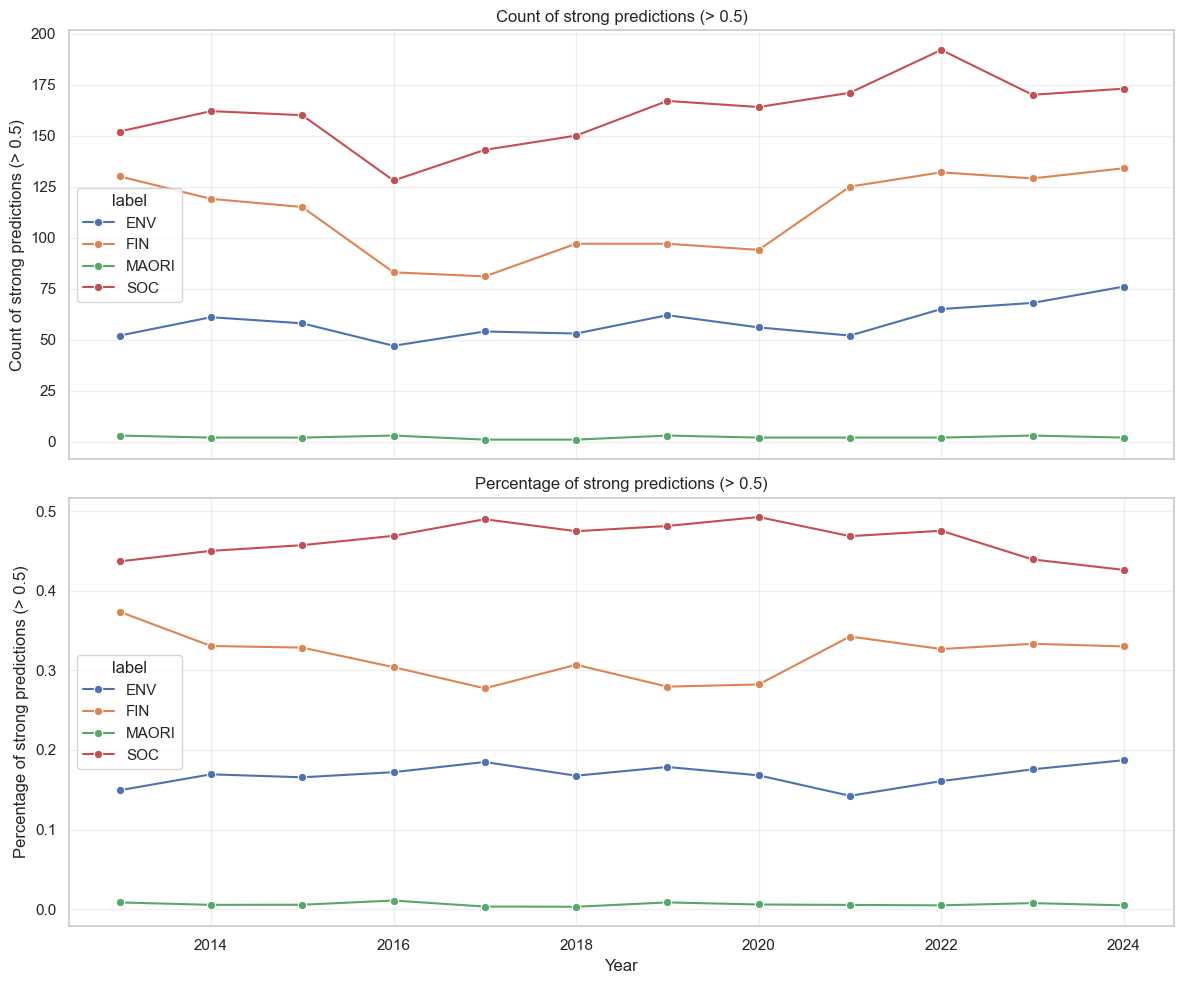

In [10]:
# Combined view for threshold > 0.5 (counts, shares)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.5)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.5)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.5)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.5)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.5)"),
]
summary = summaries[0.5]
short_labels = {
    "over_count": "Count",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


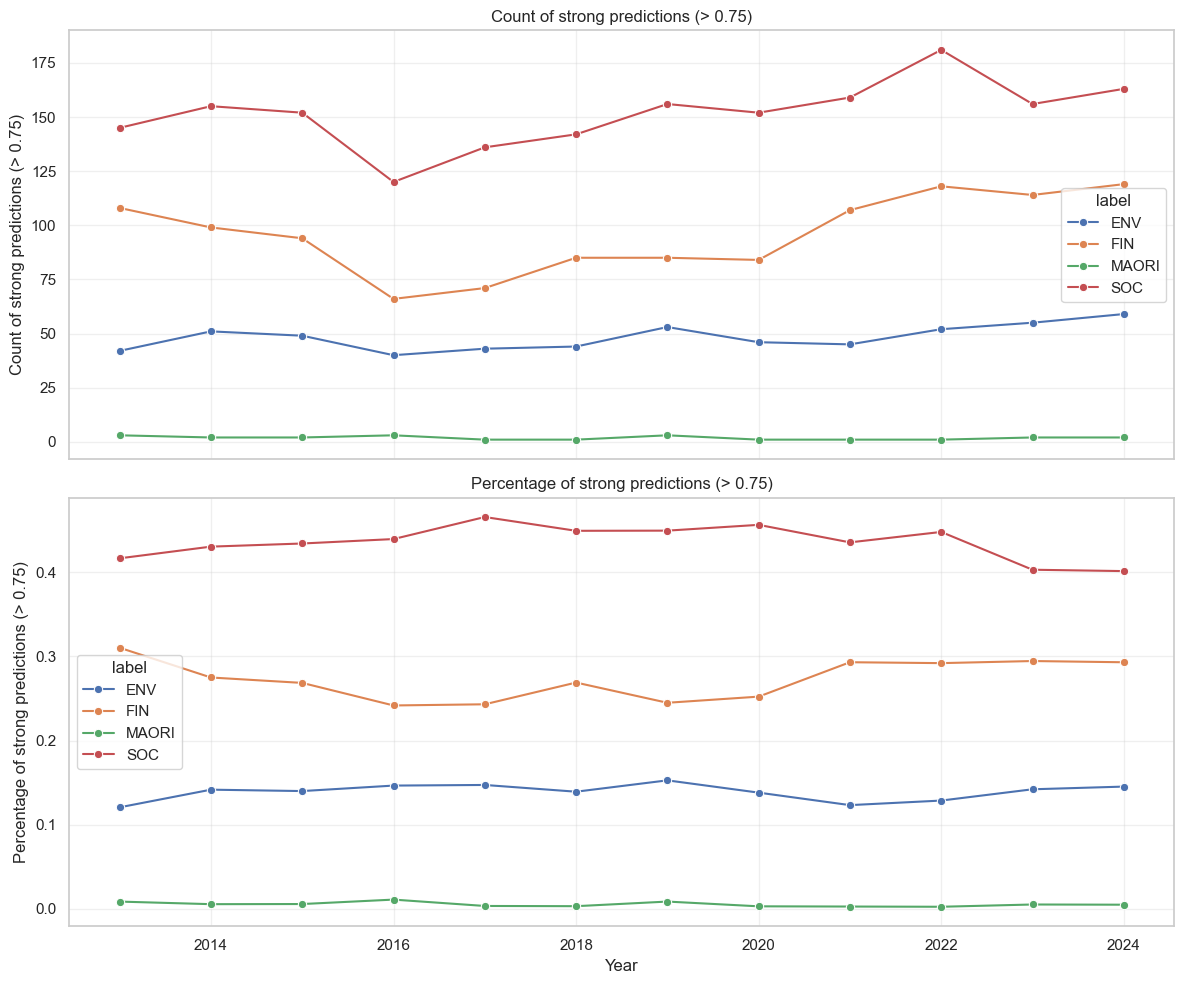

In [11]:
# Combined view for threshold > 0.75 (counts, shares)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.75)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.75)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.75)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.75)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.75)"),
]
summary = summaries[0.75]
short_labels = {
    "over_count": "Count",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


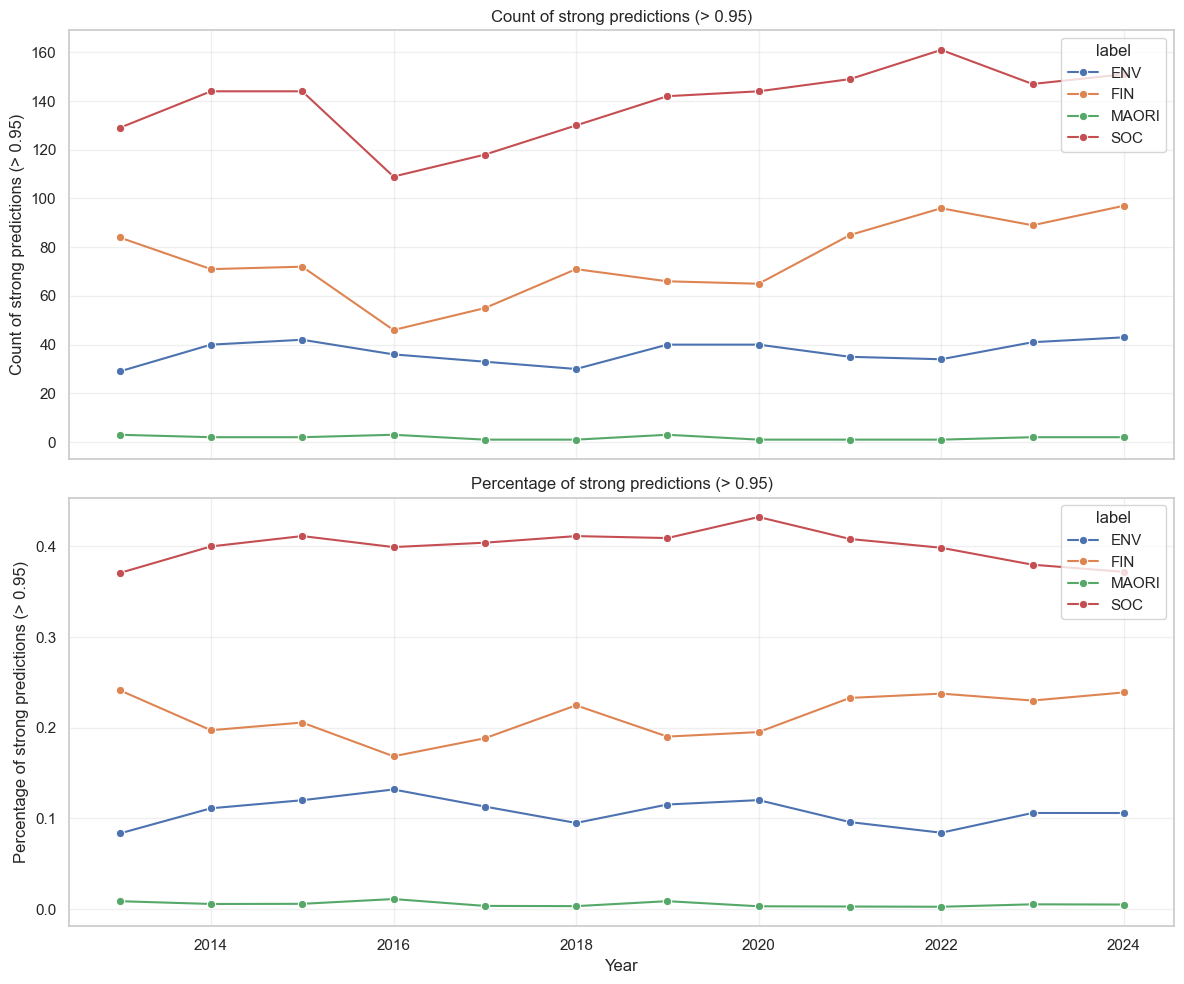

In [12]:
# Combined view for threshold > 0.95 (counts, shares)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.95)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.95)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.95)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.95)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.95)"),
]
summary = summaries[0.95]
short_labels = {
    "over_count": "Count",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- over_sentence_word_share: strong prediction sentences divided by total words in that year+label grouping.
- over_word_share: total words from strong prediction sentences divided by total words for that year+label grouping.
- over_sentences_per_page: strong prediction sentences divided by page count for that year (requires outputs/page_counts.csv).
- over_words_per_page: total words from strong prediction sentences divided by page count for that year (requires outputs/page_counts.csv).
- mean_prob_over: average probability for those sentences above the threshold (NaN if none above threshold).
